# Setup

In [1]:
from sklearn.datasets import make_blobs

import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
os.environ['OMP_NUM_THREADS'] = '8'

In [3]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)
X.shape, y.shape

((2000, 2), (2000,))

In [4]:
# X, y = make_blobs(centers=5, n_samples=2000,
#                   n_features=2, shuffle=True,
#                   random_state=7)
# print(X.shape)

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

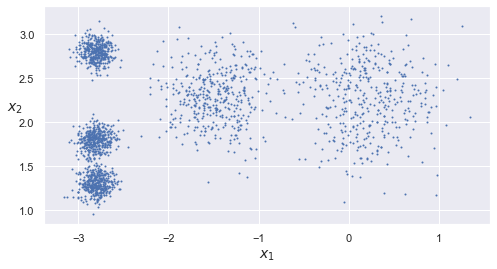

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [7]:
from sklearn.cluster import KMeans

In [8]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [9]:
kmeans.n_iter_

3

In [10]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [11]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [12]:
y_pred is kmeans.labels_

True

In [13]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

# My implementation

In [14]:
n_samples, n_features = X.shape
random_sample_idxs = np.random.choice(n_samples, 5, replace=False)
cluster_centers_ = X[random_sample_idxs].copy()
cluster_centers_.shape

(5, 2)

In [15]:
X.shape

(2000, 2)

In [16]:
def euclidean_distance(x, y):
    # vectorized version of computing all euclidean distances at once
    # https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/Broadcasting.html
    # https://stackoverflow.com/questions/27948363/numpy-broadcast-to-perform-euclidean-distance-vectorized
    squared_dists = np.sum(x**2, axis=1)[:, np.newaxis] \
                        + np.sum(y**2, axis=1) \
                        - 2 * np.dot(x, y.T)
    # clip very low negative values to 0 due to floating precisions
    return np.sqrt(np.clip(squared_dists, a_min=0, a_max=None))

In [17]:
# testing the original equation
newX = X[:, np.newaxis]
newX.shape

(2000, 1, 2)

In [18]:
# broadcasted from (2000, 1, 2) to (2000, 5, 2)
dists = newX - cluster_centers_ 
dists.shape

(2000, 5, 2)

In [19]:
distances = euclidean_distance(X, cluster_centers_)
print(distances.shape)
centroid_idxs = np.argmin(distances, axis=-1)
centroid_idxs

(2000, 5)


array([1, 3, 0, ..., 2, 4, 3], dtype=int64)

In [20]:
i = 0
sum_dists = 0
cluster_idxs = np.where(centroid_idxs == i)[0]
cluster_instances = X[cluster_idxs]
sum_dists += np.sum(np.square(
    cluster_instances[:, np.newaxis] - cluster_centers_[i]
))
sum_dists

70.26613820309463

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin

class MyKMeans(BaseEstimator, TransformerMixin, ClusterMixin):
    def __init__(self, n_clusters=8, n_init=10, 
                 max_iter=300, plot_steps=False,
                 verbose=0, random_state=42
                ):
        # initializing parameters used by the model
        self.n_clusters = n_clusters
        # number of times to run and check for the best model
        self.n_init = n_init
        self.max_iter = max_iter
        # whether to show the centroid update process in plots
        self.plot_steps = plot_steps
        self.verbose = verbose
        self.random_state = random_state
        
        # attributes
        # Coordinates of cluster centers
        self.cluster_centers_ = []
        # Labels of each instance, i.e. the index of cluster for each instance
        self.labels_ = []
        # Number of iterations run in the best n_init iteration
        self.n_iter_ = None
    
    @property
    def inertia_(self):
        """Sum of squared distances of samples to their closest cluster center"""
        sum_dists = 0
        for i in range(self.n_clusters):
            cluster_idxs = np.where(self.labels_ == i)[0]
            cluster_instances = self.X[cluster_idxs]
            sum_dists += np.sum(np.square(
                cluster_instances - self.cluster_centers_[i]
            ))
        return sum_dists
        
    def _init_centroids(self):
        """Randomly initializing cluster centroids"""
        self.n_samples, self.n_features = self.X.shape
        random_sample_idxs = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.cluster_centers_ = self.X[random_sample_idxs].copy()
    
    def _assign_clusters(self):
        distances = euclidean_distance(self.X, self.cluster_centers_)
        self.labels_ = np.argmin(distances, axis=-1)
        
    def _update_centroids(self):
        for i in range(self.n_clusters):
            cluster_idxs = np.where(self.labels_ == i)[0]
            cluster_instances = self.X[cluster_idxs]
            new_centroid = np.mean(cluster_instances, axis=0)
            self.cluster_centers_[i] = new_centroid
    
    def predict(self, X):
        if X == self.X:
            if self.verbose:
                print("[INFO] Using the same dataset being trained on.")
            return self.labels_
        distances = euclidean_distance(X, self.cluster_centers_)
        centroid_idxs = np.argmin(distances, axis=-1)
        return centroid_idxs

    def fit(self, X):
        self.X = X.copy()
        
        # initialize the best inertia value (the lower the better)
        best_inertia = np.inf
        # initialize the index for the best centroids
        best_cluster_centers_idx = 0
        # initialize the list to store all the cluster_centers_
        all_cluster_centers = []
    
        if self.verbose:
            print("[INFO] Fitting ...")
        for init_iter in range(self.n_init):
            # initialize cluster centers
            self._init_centroids()
            # initialize previous centroids
            prev_centers = self.cluster_centers_.copy()
            for i in range(self.max_iter):
                # update cluster labels
                self._assign_clusters()

                # update cluster centers
                self._update_centroids()

                # check if centroids changed
                if i > 1 and np.allclose(self.cluster_centers_, prev_centers):
                    if self.verbose:
                        print("[INFO] Converged!")
                    break

                # set the previous centroids to be the current one
                prev_centers = self.cluster_centers_.copy()

                if self.plot_steps:
                    self.plot()

            # set the total iterations run
            self.n_iter_ = i
            # update inertia
            current_inertia = self.inertia_
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_cluster_centers_idx = init_iter
            if self.verbose:
                print(f"{init_iter = }")
                print(f"{best_inertia = }")
                print(f"{best_cluster_centers_idx = }\n")
                
            all_cluster_centers.append(self.cluster_centers_)
        
        # set back the cluster centers to the one that had the lowest inertia
        self.cluster_centers_ = all_cluster_centers[best_cluster_centers_idx]
        self._assign_clusters()
                
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)
    
    def plot(self, X=None, circle_color='w', cross_color='k', title=None):
        if X is None:
            if self.verbose:
                print("[INFO] Using the same dataset being trained on.")
            X = self.X
            labels = self.labels_
        else:
            labels = self.predict(X)
            
        plt.figure(figsize=(12, 8))
        
        plt.scatter(X[:, 0], X[:, 1],
                    c=labels, cmap='tab20b')
        
        centroids = self.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='o', s=30, linewidths=8,
                    color=circle_color, zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=50, linewidths=2,
                    color=cross_color, zorder=11, alpha=1)
        plt.title(title)

        plt.show()

In [2]:
import numpy as np
a = np.arange(6).reshape(2,3) + 10
print(a)
print(np.argmin(a))
print(np.argmin(a, axis=0))
print(np.argmin(a, axis=1))

[[10 11 12]
 [13 14 15]]
0
[0 0 0]
[0 0]


In [22]:
k = 5
my_kmeans = MyKMeans(n_clusters=k, plot_steps=False, verbose=0)
my_kmeans.fit(X)

In [23]:
# total iterations taken to converge
my_kmeans.n_iter_

4

In [24]:
print("Inertia")
print("--" * 6)
print(f"My implementation\t: {my_kmeans.inertia_}")
print(f"Sklearn implementation\t: {kmeans.inertia_}")

Inertia
------------
My implementation	: 211.59853725816836
Sklearn implementation	: 211.59853725816828


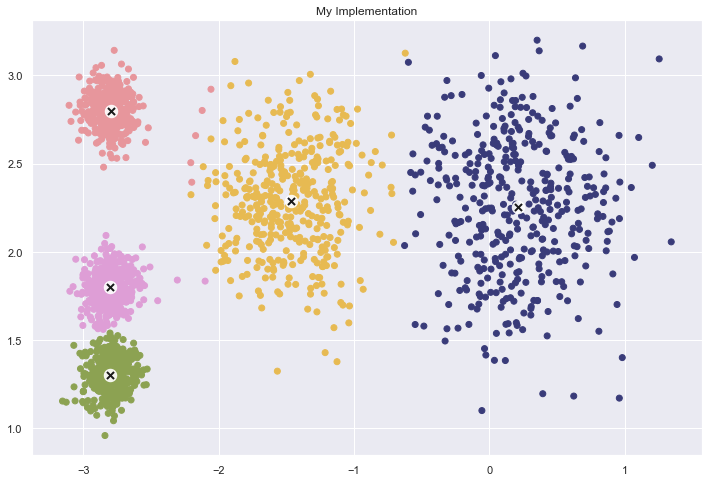

In [25]:
my_kmeans.plot(title='My Implementation')

# Visualizations

In [26]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=2,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

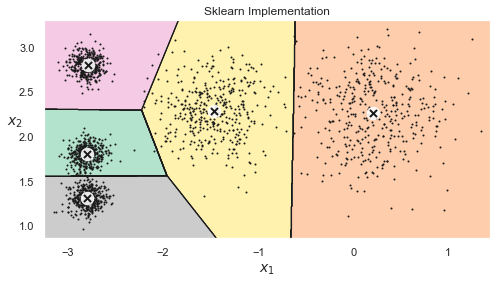

Wall time: 484 ms


In [27]:
%%time
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title('Sklearn Implementation')
plt.show()

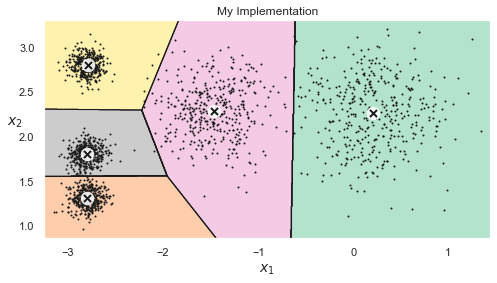

Wall time: 543 ms


In [28]:
%%time
plt.figure(figsize=(8, 4))
plot_decision_boundaries(my_kmeans, X)
plt.title('My Implementation')
plt.show()

## KMeans update concepts

In [29]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

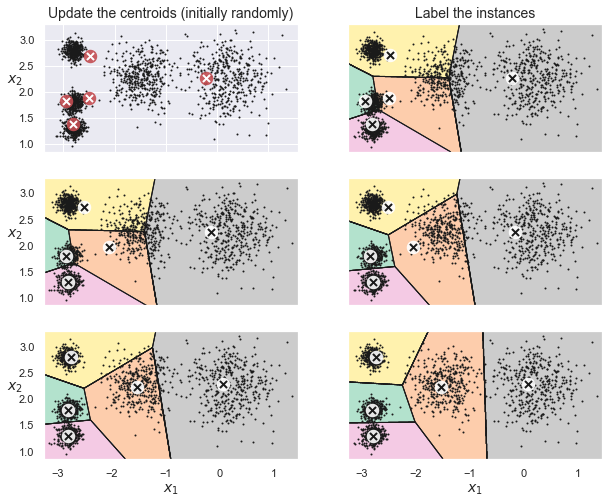

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

# Determine best cluster

## Inertia

In [31]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

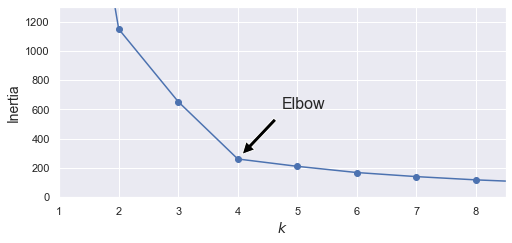

In [32]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

## Silhouette score

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. 
- An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$
- where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_),
- and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster).
- The silhouette coefficient can vary between -1 and +1:
- a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters,
- while a coefficient close to 0 means that it is close to a cluster boundary,
- and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [33]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [34]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

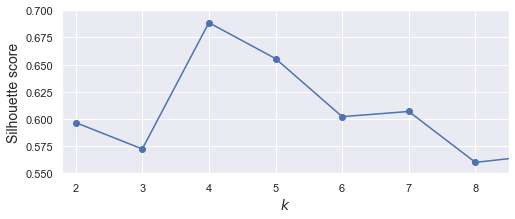

In [35]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

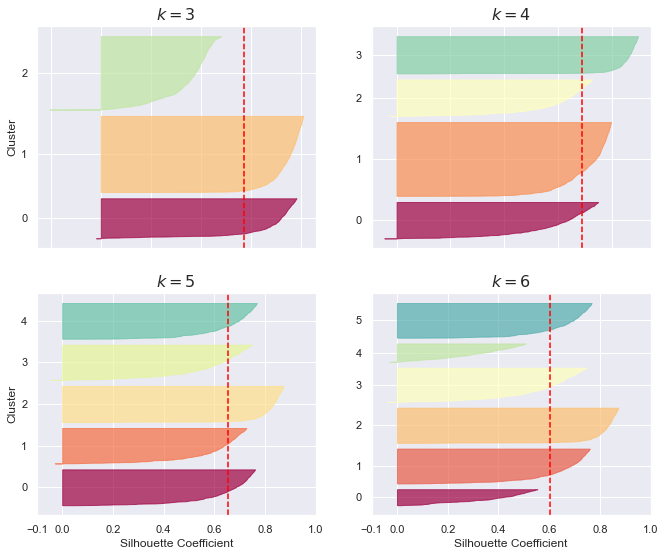

In [36]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()